<a href="https://colab.research.google.com/github/canon14/MovieRecommendationModel/blob/main/NLP_TMDBMovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from scipy.stats import gaussian_kde

%matplotlib inline

In [164]:
tmdb_attributes_df = pd.read_csv('/content/tmdb_attributes.csv')
tmdb_genres_df = pd.read_csv('/content/tmdb_genres.csv')

##Data Cleaning, Transformation, and Exploration

In [165]:
#Create separate dataframes to group genres (genre count and lists)
#Genre Count
genre_count_df = tmdb_genres_df.groupby(['title', 'movieID'],as_index=False).count().rename(columns={'genre' : 'genre_counts'})
genre_count_df = genre_count_df.drop('Unnamed: 0', axis=1)

#Group Genre into lists 
genre_lists_df = tmdb_genres_df.groupby(['title', 'movieID'])['genre'].apply(list).reset_index(name='genres')

In [166]:
#Join all the created dataframes into tmdb_attributes
genre_count_lists_df = genre_lists_df.merge(genre_count_df, how='inner', on=['title', 'movieID'])

tmdb_attributes_df = tmdb_attributes_df.merge(genre_count_lists_df, how='inner', left_on='id', right_on='movieID')

#rename and drop columns
tmdb_attributes_df = tmdb_attributes_df.drop(['title_x', 'title_y', 'movieID'], axis=1).rename(columns={'id': 'movie_id', 'original_title':'title'})

#create a new column to store genres information in string and not list
tmdb_attributes_df['genre_string'] = ['  '.join(map(str, l)) for l in tmdb_attributes_df['genres']]

#fill empty value for runtime with the mean (since we only have 2 missing values)
tmdb_attributes_df['runtime'] = tmdb_attributes_df['runtime'].fillna(tmdb_attributes_df['runtime'].mean())

# changing the release_date format
tmdb_attributes_df['release_date'] = pd.to_datetime(tmdb_attributes_df['release_date'])

In [167]:
tmdb_attributes_df

,budget,movie_id,original_language,title,popularity,release_date,revenue,runtime,tagline,vote_average,vote_count,genres,genre_counts,genre_string
0,237000000,19995,en,Avatar,150.437577,2009-12-10,2787965087,162.0,Enter the World of Pandora.,7.2,11800,"[Action, Adventure, Fantasy, SciFi]",4,Action Adventure Fantasy SciFi
1,300000000,285,en,Pirates of the Caribbean: At World's End,139.082615,2007-05-19,961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"[Adventure, Fantasy, Action]",3,Adventure Fantasy Action
2,245000000,206647,en,Spectre,107.376788,2015-10-26,880674609,148.0,A Plan No One Escapes,6.3,4466,"[Action, Adventure, Crime]",3,Action Adventure Crime
3,250000000,49026,en,The Dark Knight Rises,112.312950,2012-07-16,1084939099,165.0,The Legend Ends,7.6,9106,"[Action, Crime, Drama, Thriller]",4,Action Crime Drama Thriller
4,260000000,49529,en,John Carter,43.926995,2012-03-07,284139100,132.0,"Lost in our world, found in another.",6.1,2124,"[Action, Adventure, SciFi]",3,Action Adventure SciFi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,0,67238,en,Cavite,0.022173,2005-03-12,0,80.0,NaN,7.5,2,"[Foreign, Thriller]",2,Foreign Thriller
4771,220000,9367,es,El Mariachi,14.269792,1992-09-04,2040920,81.0,"He didn't come looking for trouble, but troubl...",6.6,238,"[Action, Crime, Thriller]",3,Action Crime Thriller
4772,9000,72766,en,Newlyweds,0.642552,2011-12-26,0,85.0,A newlywed couple's honeymoon is upended by th...,5.9,5,"[Comedy, Romance]",2,Comedy Romance
4773,0,231617,en,"Signed, Sealed, Delivered",1.444476,2013-10-13,0,120.0,NaN,7.0,6,"[Comedy, Drama, Romance, TV Movie]",4,Comedy Drama Romance TV Movie


In [168]:
tmdb_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 4774
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   budget             4775 non-null   int64         
 1   movie_id           4775 non-null   int64         
 2   original_language  4775 non-null   object        
 3   title              4775 non-null   object        
 4   popularity         4775 non-null   float64       
 5   release_date       4775 non-null   datetime64[ns]
 6   revenue            4775 non-null   int64         
 7   runtime            4775 non-null   float64       
 8   tagline            3956 non-null   object        
 9   vote_average       4775 non-null   float64       
 10  vote_count         4775 non-null   int64         
 11  genres             4775 non-null   object        
 12  genre_counts       4775 non-null   int64         
 13  genre_string       4775 non-null   object        
dtypes: datet

In [169]:
#Generate the summary statistics for the data
tmdb_attributes_df.describe()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,genre_counts
count,4.775000e+03,4775.000000,4775.000000,4.775000e+03,4775.000000,4775.000000,4775.000000,4775.000000
mean,2.921458e+07,55988.208796,21.617344,8.274265e+07,107.207207,6.114199,694.257382,2.546597
std,4.078120e+07,87310.177303,31.867749,1.632119e+08,21.956016,1.140636,1237.070089,1.107292
min,0.000000e+00,5.000000,0.000372,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,9.500000e+05,8998.500000,4.806600,0.000000e+00,94.000000,5.600000,55.000000,2.000000
50%,1.500000e+07,14536.000000,13.119133,1.947206e+07,104.000000,6.200000,238.000000,2.000000
75%,4.000000e+07,57206.500000,28.499077,9.357130e+07,118.000000,6.800000,742.000000,3.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,7.000000


In [170]:
# Generate the correlation between different features in the data
tmdb_attributes_df.corr()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,genre_counts
budget,1.000000,-0.081545,0.504032,0.730347,0.268254,0.084173,0.592273,0.264131
movie_id,-0.081545,1.000000,0.040926,-0.044576,-0.119795,-0.243504,0.003348,-0.136362
popularity,0.504032,0.040926,1.000000,0.644069,0.222974,0.275098,0.777671,0.148471
revenue,0.730347,-0.044576,0.644069,1.000000,0.251824,0.197448,0.781132,0.178318
runtime,0.268254,-0.119795,0.222974,0.251824,1.000000,0.347283,0.272607,0.068305
vote_average,0.084173,-0.243504,0.275098,0.197448,0.347283,1.000000,0.318236,0.046842
vote_count,0.592273,0.003348,0.777671,0.781132,0.272607,0.318236,1.000000,0.148988
genre_counts,0.264131,-0.136362,0.148471,0.178318,0.068305,0.046842,0.148988,1.000000


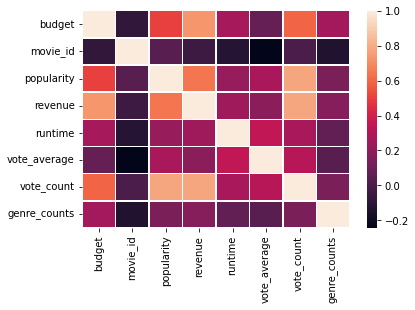

In [171]:
#Visualize the correlation between features
corr = tmdb_attributes_df.corr()
sns.heatmap(corr, linewidths=.5)

## Module 4 - NLP

###Wordclouds
Wordclouds are excellent ways to summarize textual information like reviews, customer feedback, documents etc. The first part of this excercise focuses on creating a word cloud from the text descriptions in the wine dataset that you have seen earlier in Part 1.

In [172]:
artist_attributes_df = pd.read_csv('/content/artist_attributes.csv')
artist_to_imdb_df = pd.read_csv('/content/artist_to_imdb.csv')
links_df = pd.read_csv('/content/links.csv')
tmdb_keywords_df = pd.read_csv('/content/tmdb_keywords.csv')
tmdb_overview_keywords_df = pd.read_csv('/content/tmdb_overview_keywords.csv')

In [173]:
!pip install wordcloud

In [174]:
#Import necessary libraries
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import FreqDist

import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [175]:
NLP_tmdb_attributes_df = tmdb_attributes_df.copy()

In [176]:
NLP_tmdb_attributes_df.head()

,budget,movie_id,original_language,title,popularity,release_date,revenue,runtime,tagline,vote_average,vote_count,genres,genre_counts,genre_string
0,237000000,19995,en,Avatar,150.437577,2009-12-10,2787965087,162.0,Enter the World of Pandora.,7.2,11800,"[Action, Adventure, Fantasy, SciFi]",4,Action Adventure Fantasy SciFi
1,300000000,285,en,Pirates of the Caribbean: At World's End,139.082615,2007-05-19,961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"[Adventure, Fantasy, Action]",3,Adventure Fantasy Action
2,245000000,206647,en,Spectre,107.376788,2015-10-26,880674609,148.0,A Plan No One Escapes,6.3,4466,"[Action, Adventure, Crime]",3,Action Adventure Crime
3,250000000,49026,en,The Dark Knight Rises,112.312950,2012-07-16,1084939099,165.0,The Legend Ends,7.6,9106,"[Action, Crime, Drama, Thriller]",4,Action Crime Drama Thriller
4,260000000,49529,en,John Carter,43.926995,2012-03-07,284139100,132.0,"Lost in our world, found in another.",6.1,2124,"[Action, Adventure, SciFi]",3,Action Adventure SciFi


In [177]:
#Get artists information

artist_df = artist_to_imdb_df.merge(artist_attributes_df, how='inner', on='artist_id')

artist_df = artist_df.groupby(['imdb_id'])['name'].apply(list).reset_index(name='artist_list')
#create a new column to store artists information in string and not list
artist_df['artists'] = ['  '.join(map(str, l)) for l in artist_df['artist_list']]

links_df = links_df.merge(artist_df, how='inner', left_on='imdbId', right_on='imdb_id')
links_df = links_df[['tmdbId', 'artists']]
links_df['tmdbId'] = links_df['tmdbId'].astype("Int64")

links_df = links_df.dropna()

In [178]:
#Get keywords information 

tmdb_keywords_df = tmdb_keywords_df.groupby(['title', 'movieID'])['keyword'].apply(list).reset_index(name='keywords1_list')
#create a new column to store keywords information in string and not list
tmdb_keywords_df['keywords1'] = ['  '.join(map(str, l)) for l in tmdb_keywords_df['keywords1_list']]

tmdb_overview_keywords_df = tmdb_overview_keywords_df.groupby(['title', 'TMDB ID'])['keyword'].apply(list).reset_index(name='keywords2_list')
#create a new column to store overview_keywords information in string and not list
tmdb_overview_keywords_df['overview_keywords'] = ['  '.join(map(str, l)) for l in tmdb_overview_keywords_df['keywords2_list']]

In [179]:
#Join all supplemental tables to NLP_tmdb_keywords_df
NLP_tmdb_attributes_df = NLP_tmdb_attributes_df.merge(tmdb_keywords_df, how='left', left_on='movie_id', right_on='movieID')
NLP_tmdb_attributes_df = NLP_tmdb_attributes_df.merge(tmdb_overview_keywords_df, how='left', left_on='movie_id', right_on='TMDB ID')

NLP_tmdb_attributes_df = NLP_tmdb_attributes_df.merge(links_df, how='left', left_on='movie_id', right_on='tmdbId')

In [180]:
NLP_tmdb_attributes_df['tagline'] = NLP_tmdb_attributes_df['tagline'].str.replace(',', '')
NLP_tmdb_attributes_df['tagline'] = NLP_tmdb_attributes_df['tagline'].str.replace('.', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [181]:
NLP_tmdb_attributes_df = NLP_tmdb_attributes_df[['title_x', 'original_language', 'tagline', 'genre_string', 'keywords1', 'overview_keywords', 'artists']]

In [182]:
#Fill all the NULLS with empty string
NLP_tmdb_attributes_df = NLP_tmdb_attributes_df.fillna('')

In [183]:
NLP_tmdb_attributes_df['combined'] = NLP_tmdb_attributes_df['title_x'] + ' ' + NLP_tmdb_attributes_df['original_language'] + ' ' + NLP_tmdb_attributes_df['tagline'] + ' ' + NLP_tmdb_attributes_df['genre_string'] \
                                   + ' ' + NLP_tmdb_attributes_df['keywords1'] + ' ' + NLP_tmdb_attributes_df['overview_keywords'] + ' ' + NLP_tmdb_attributes_df['artists']

NLP_tmdb_attributes_df['index'] = NLP_tmdb_attributes_df.index

In [184]:
NLP_tmdb_attributes_df

,title_x,original_language,tagline,genre_string,keywords1,overview_keywords,artists,combined,index
0,Avatar,en,Enter the World of Pandora,Action Adventure Fantasy SciFi,culture clash future space war space colony...,22nd century paraplegic Marine orders moon ...,James Horner James Cameron Sigourney Weaver ...,Avatar en Enter the World of Pandora Action A...,0
1,Pirates of the Caribbean: At World's End,en,At the end of the world the adventure begins,Adventure Fantasy Action,ocean drug abuse exotic island east india t...,Captain Barbossa life edge of the Earth Wil...,Johnny Depp Jerry Bruckheimer Lee Arenberg ...,Pirates of the Caribbean: At World's End en At...,1
2,Spectre,en,A Plan No One Escapes,Action Adventure Crime,spy based on novel secret agent sequel mi6...,political forces cryptic message secret serv...,Nigel Barber Lucas Bielan Jez Butterworth J...,Spectre en A Plan No One Escapes Action Adven...,2
3,The Dark Knight Rises,en,The Legend Ends,Action Crime Drama Thriller,dc comics crime fighter terrorist secret id...,Gotham City Police Department Dent s crimes ...,Matthew Modine Su Whitaker Anne Hathaway Al...,The Dark Knight Rises en The Legend Ends Actio...,3
4,John Carter,en,Lost in our world found in another,Action Adventure SciFi,based on novel mars medallion space travel ...,John Carter exotic planet of Barsoom Mars we...,Mark Andrews Edgar Rice Burroughs Michael Ch...,John Carter en Lost in our world found in anot...,4
...,...,...,...,...,...,...,...,...,...
4770,Cavite,en,,Foreign Thriller,,male voice Adam doesn t phone rings native ...,,Cavite en Foreign Thriller male voice Adam...,4770
4771,El Mariachi,es,He didn't come looking for trouble but trouble...,Action Crime Thriller,united states–mexico barrier legs arms pape...,drug lord El Mariachi family tradition guit...,Robert Rodriguez Carlos Gallardo Elizabeth A...,El Mariachi es He didn't come looking for trou...,4771
4772,Newlyweds,en,A newlywed couple's honeymoon is upended by th...,Comedy Romance,,newlywed couple s honeymoon arrivals of their...,,Newlyweds en A newlywed couple's honeymoon is ...,4772
4773,"Signed, Sealed, Delivered",en,,Comedy Drama Romance TV Movie,date love at first sight narration investig...,elite team post office dedicated quartet of ...,,"Signed, Sealed, Delivered en Comedy Drama R...",4773


In [185]:
print(NLP_tmdb_attributes_df.combined[1])

Pirates of the Caribbean: At World's End en At the end of the world the adventure begins Adventure  Fantasy  Action ocean  drug abuse  exotic island  east india trading company  love of one's life  traitor  shipwreck  strong woman  ship  alliance  calypso  afterlife  fighter  pirate  swashbuckler  aftercreditsstinger Captain Barbossa  life  edge of the Earth  Will Turner  Elizabeth Swann Johnny Depp  Jerry Bruckheimer  Lee Arenberg  Peter Donald Badalamenti II  David Bailie  Vanessa Branch  Sergio Calderón  Curt Clendenin  Mackenzie Crook  Peter Flynn  Steven Ho  Marcel Iures  Reggie Lee  James S. Levine  Eric McLeod  Kevin McNally  Keith Richards  John Sponsler  Steve Tartalia  Jay Wolpert  Craig Wood  Giles New  Marty Murray  Ilram Choi  Ned Lott  Michelle Lee


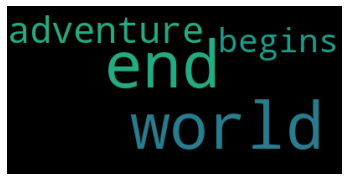

In [186]:
# Start with one review:
text = NLP_tmdb_attributes_df.tagline[1]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [187]:
#combine all the descriptions into one big text variable
text = " ".join(tagline for tagline in NLP_tmdb_attributes_df.combined)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 2368588 words in the combination of all review.


In [188]:
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(text)
freq = FreqDist(tokens)

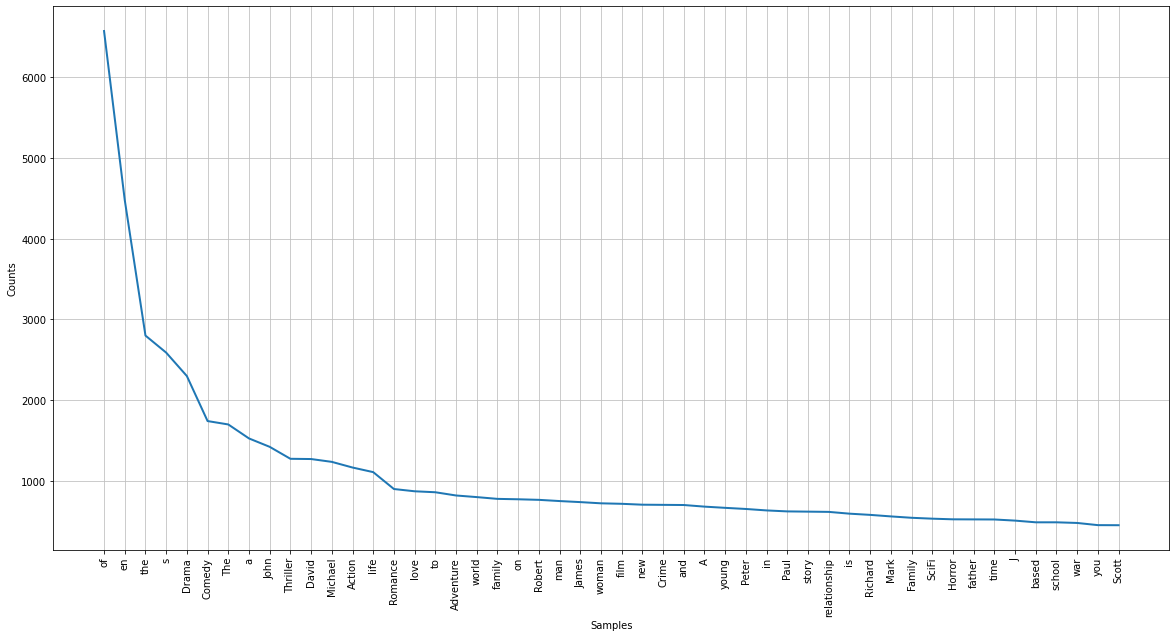

In [189]:
plt.rcParams["figure.figsize"] = (20,10)
freq.plot(50)

Zipf's law
The distribution of text follows a Zipf's or scale-free distribution. This is quite characteristic of any naturally occuring text corpus, irrespective of language.

What is the most commonly occuring word?

### Stopwords

Some words like the, and etc. even though commonly occuring do not add a lot of value as they are not unique to the context. In addition, we might wish to remove commonly occuring words for a specific context, e.g. "wine", and "drink". 

In [190]:
# Create stopword list:
stopwords = set(STOPWORDS)

## Add a set of stopwords specific to the movie descriptions and generate another wordcloud

In [191]:
stopwords.update(["Drama"]) # <-- Change the parameter inside to whatever you would like to analyse 

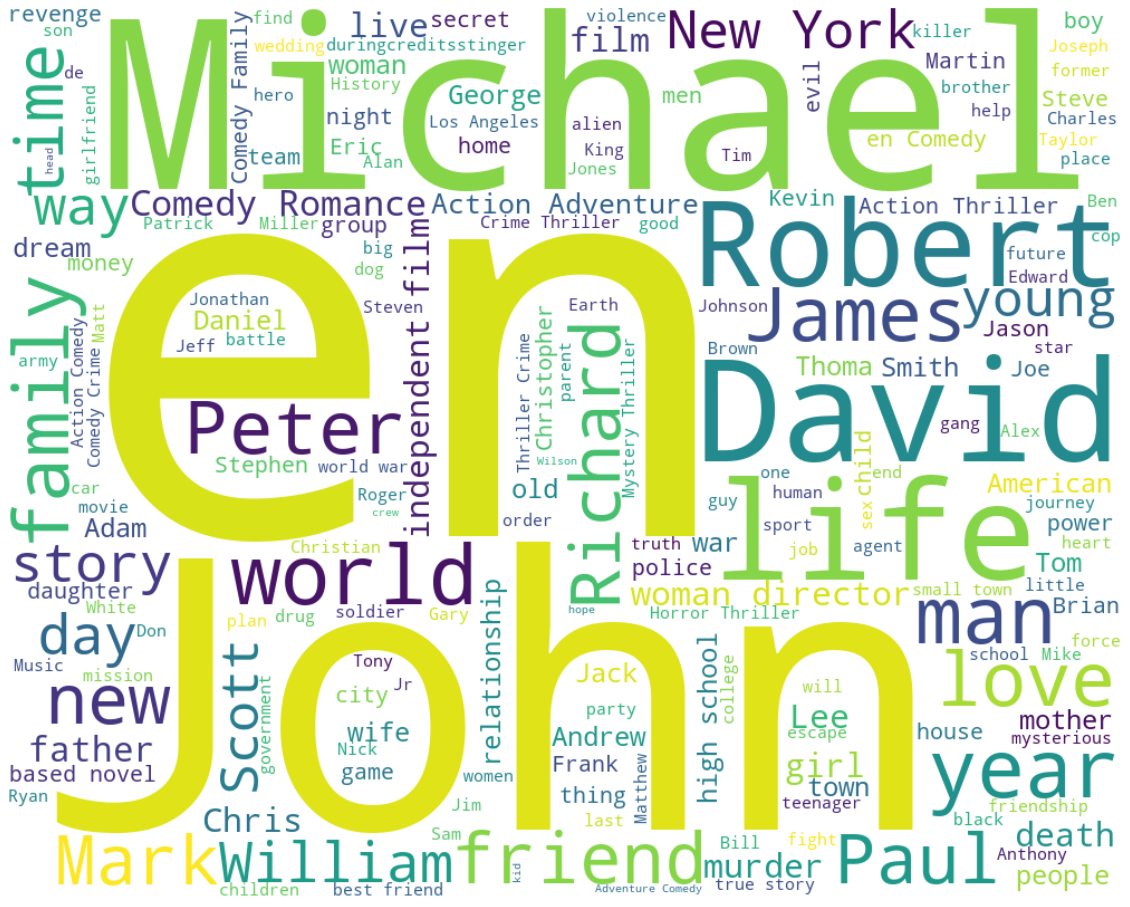

In [192]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1000, height=800).generate(text)

# Display the generated image:
# the matplotlib way:
plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## FINAL - Movie Recommendation Systems 

In [193]:
matrix = CountVectorizer()

In [194]:
out = matrix.fit_transform(NLP_tmdb_attributes_df['combined'])

In [195]:
# print(matrix.get_feature_names())

In [196]:
print(out.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [197]:
similarity = cosine_similarity(out)

In [198]:
#Cosine Similarity
print(similarity)

[[1.         0.16829646 0.05418532 ... 0.06010588 0.06814125 0.01064613]
 [0.16829646 1.         0.07042952 ... 0.175      0.19232188 0.02214037]
 [0.05418532 0.07042952 1.         ... 0.04225771 0.0342193  0.01247469]
 ...
 [0.06010588 0.175      0.04225771 ... 1.         0.16195527 0.02214037]
 [0.06814125 0.19232188 0.0342193  ... 0.16195527 1.         0.05378625]
 [0.01064613 0.02214037 0.01247469 ... 0.02214037 0.05378625 1.        ]]


In [199]:
def get_title_from_index(index):
  return NLP_tmdb_attributes_df['title_x'][index]

def get_index_from_title(title):
  return NLP_tmdb_attributes_df[NLP_tmdb_attributes_df.title_x == title]['index'].values[0] 

#Test our completed model

In [200]:
movie = 'The Dark Knight Rises'  # <-- Movie title is changeable
movie_index=get_index_from_title(movie)
similar_movies = list(enumerate(similarity[movie_index]))

In [201]:
sort = sorted(similar_movies, key=lambda x:x[1], reverse=True)[1:]

In [203]:
print('Top 10 Recommended Movies are:')
print()
for i in range(0,10):
    print(get_title_from_index(sort[i][0]))
    print()

Top 10 Recommended Movies are:

The Dark Knight

Batman Begins

Batman Returns

Batman

Batman Forever

Batman: The Dark Knight Returns, Part 2

Batman & Robin

Teenage Mutant Ninja Turtles II: The Secret of the Ooze

Defendor

Slow Burn

